In [1]:
try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
from tensorflow.keras.layers import Input, SimpleRNN, GRU, LSTM, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [0]:
# make the original data
series = np.sin((0.1*np.arange(400))**2)

This is a time series of the form:

$$ x(t) = \sin(\omega t^2) $$

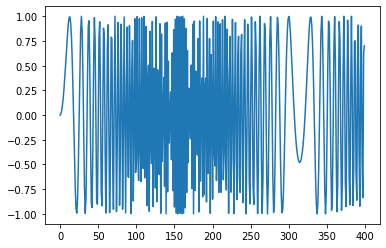

In [3]:
# plot it
plt.plot(series)
plt.show()

In [4]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T) # make it N x T
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (390, 10) Y.shape (390,)


In [5]:
### try autoregressive linear model
i = Input(shape=(T,))
x = Dense(1)(i)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.01),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Train on 195 samples, validate on 195 samples
Epoch 1/80
195/195 [==============================] - 1s 7ms/sample - loss: 2.1687 - val_loss: 1.7022
Epoch 2/80
195/195 [==============================] - 0s 192us/sample - loss: 1.8109 - val_loss: 1.5199
Epoch 3/80
195/195 [==============================] - 0s 195us/sample - loss: 1.5217 - val_loss: 1.3679
Epoch 4/80
195/195 [==============================] - 0s 192us/sample - loss: 1.2947 - val_loss: 1.2277
Epoch 5/80
195/195 [==============================] - 0s 189us/sample - loss: 1.0922 - val_loss: 1.0863
Epoch 6/80
195/195 [==============================] - 0s 167us/sample - loss: 0.9443 - val_loss: 0.9750
Epoch 7/80
195/195 [==============================] - 0s 161us/sample - loss: 0.8209 - val_loss: 0.8987
Epoch 8/80
195/195 [==============================] - 0s 192us/sample - loss: 0.7297 - val_loss: 0.8416
Epoch 9/80
195/195 [==============================] - 0s 188us/sample - loss: 0.6645 - val_loss: 0.7910
Epoch 10/80
195/195 

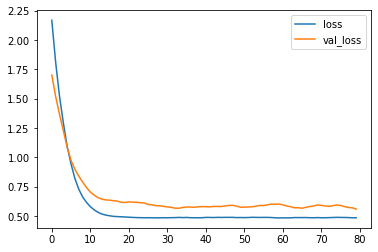

In [6]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(390, 1)


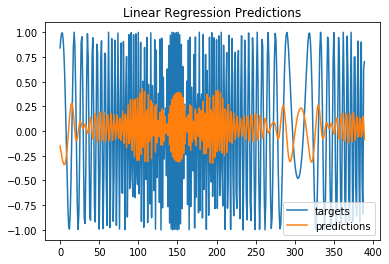

In [7]:
# One-step forecast using true targets
# Note: even the one-step forecast fails badly
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.title("Linear Regression Predictions")
plt.legend()
plt.show()

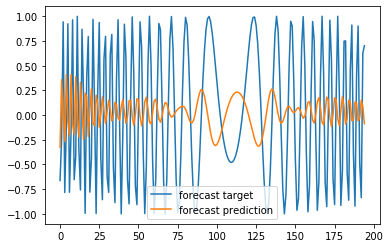

In [8]:
# One-step forecast using true targets

validation_target = Y[-N//2:]
validation_predictions = []

# index of first validation input
i = -N//2

while len(validation_predictions) < len(validation_target):
  p = model.predict(X[i].reshape(1, -1))[0,0] # 1x1 array -> scalar
  i += 1
  
  # update the predictions list
  validation_predictions.append(p)

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

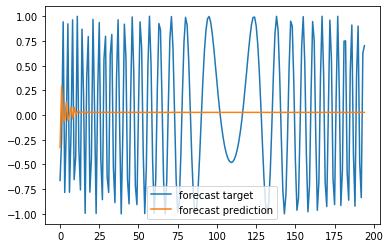

In [9]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, -1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [10]:
### Now try RNN/LSTM model
X = X.reshape(-1, T, 1) # make it N x T x D

# make the RNN
i = Input(shape=(T, D))
x = LSTM(10)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.05),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  batch_size=32,
  epochs=200,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Train on 195 samples, validate on 195 samples
Epoch 1/200
195/195 [==============================] - 4s 21ms/sample - loss: 0.5321 - val_loss: 0.5760
Epoch 2/200
195/195 [==============================] - 0s 297us/sample - loss: 0.5081 - val_loss: 0.5615
Epoch 3/200
195/195 [==============================] - 0s 264us/sample - loss: 0.4390 - val_loss: 0.4663
Epoch 4/200
195/195 [==============================] - 0s 240us/sample - loss: 0.3283 - val_loss: 0.4362
Epoch 5/200
195/195 [==============================] - 0s 240us/sample - loss: 0.2322 - val_loss: 0.4255
Epoch 6/200
195/195 [==============================] - 0s 251us/sample - loss: 0.2533 - val_loss: 0.4558
Epoch 7/200
195/195 [==============================] - 0s 264us/sample - loss: 0.3735 - val_loss: 0.5124
Epoch 8/200
195/195 [==============================] - 0s 259us/sample - loss: 0.2126 - val_loss: 0.4600
Epoch 9/200
195/195 [==============================] - 0s 242us/sample - loss: 0.2358 - val_loss: 0.3332
Epoch 10/2

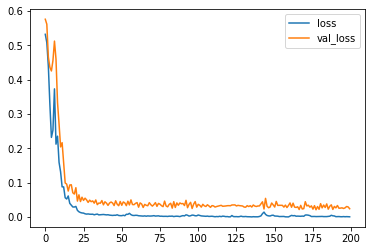

In [11]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

(390, 1)


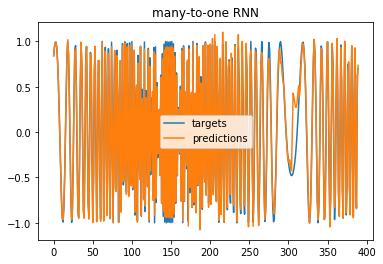

In [12]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.title("many-to-one RNN")
plt.legend()
plt.show()

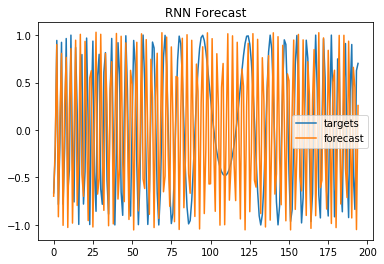

In [13]:
# Multi-step forecast
forecast = []
input_ = X[-N//2]
while len(forecast) < len(Y[-N//2:]):
  # Reshape the input_ to N x T x D
  f = model.predict(input_.reshape(1, T, 1))[0,0]
  forecast.append(f)

  # make a new input with the latest forecast
  input_ = np.roll(input_, -1)
  input_[-1] = f

plt.plot(Y[-N//2:], label='targets')
plt.plot(forecast, label='forecast')
plt.title("RNN Forecast")
plt.legend()
plt.show()